In [1]:
%load_ext rpy2.ipython

In [2]:
import pandas as pd
import scipy.io as io
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import numpy as np
from matplotlib import gridspec
import seaborn as sns
import datetime
from datetime import datetime, timedelta
import pickle
import itertools
import glob

In [3]:
import matplotlib.dates as dates
from scipy import stats
from scipy.stats import variation
import math
from sklearn import preprocessing
from scipy.signal import butter, filtfilt
import itertools

In [4]:
import matplotlib.pyplot as plt
#font = {'family': 'serif', 'serif': ['Palatino']}
font = {'family': 'serif', 'serif': ['Helvetica']}
plt.rc('font', **font)
plt.rc('text', usetex=False)

In [5]:
label_fontsize = 16
title_fontsize = 16

In [6]:
#Set up parameters for figure display
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (8, 8),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'axes.labelweight': 'bold',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}

pylab.rcParams.update(params)
pylab.rcParams["font.family"] = "serif"
pylab.rcParams["font.weight"] = "heavy"
#pylab.rcParams.update({'figure.autolayout': True})

In [7]:
sns.set(font_scale=1.25, style="whitegrid")

In [8]:
def process_RTs(subjid,summarystat_df):
    beh_file = base_dir + beh_files + 's_' + subjid + '_behaviour.csv'
    RT_data = pd.read_csv(beh_file)
    RT_data['subj_idx'] = subjid
    RT_data = RT_data.drop('Subj_id', 1)
    RT_data = RT_data.loc[RT_data.Alertness.isin(['Alert', 'Drowsy']),:] #choose only alert and drowsy trials..
    RT_data = RT_data.rename(columns={'Alertness': 'state'})
    
    stat_data = RT_data.dropna(how='any')
    
    
# Don't do stats on single subject, as it doesn't make sense..    
    t_stat,p_val = stats.ttest_ind(stat_data.loc[stat_data['state'] == 'Alert', 'RT'], 
                                   stat_data.loc[stat_data['state'] == 'Drowsy', 'RT'])
    df_test = len(stat_data)-1
    
    if p_val<0.01:
       p_val = 0.01
    else:
       p_val = round(p_val,3)
    
    summarystat_df = summarystat_df.append({'subject': subjid, 't_stat': round(t_stat,2), 
                             'p_val': p_val, 'df': df_test}, ignore_index=True)

#     alert_variation = np.round(variation(stat_data.loc[stat_data['state'] == 'Alert', 'RT']),2)
#     drowsy_variation = np.round(variation(stat_data.loc[stat_data['state'] == 'Drowsy', 'RT']),2)
    
#     summarystat_df = summarystat_df.append({'subject': subjid, 'alert': alert_variation,
#                                             'drowsy': drowsy_variation, 'status':status,
#                                             }, ignore_index=True)               

    return stat_data, summarystat_df

In [49]:
def plot_RTs(data, summarystat, pal, ax, x_label, y_label, title):

    ax2 = sns.violinplot(x="state",y="RT",data=data, palette = pal, ax = ax)

    ax3 = sns.stripplot(x="state",y="RT",data=data, jitter=True, linewidth=0.5, ax=ax,edgecolor ="black",
                         palette=pal)

    if summarystat['p_val'].values[0]>0.05:
        p_str = ', p' + ' >0.05'
    elif (summarystat['p_val'].values[0]<=0.05) & (summarystat['p_val'].values[0]>0.01):
        p_str = ', p' + ' <0.05*'
    elif summarystat['p_val'].values[0]<=0.01:
        p_str = ', p' + ' <0.01**'
    
    string_val = 't('+ str(int(summarystat['df'].values[0])) + ')= ' + str(summarystat['t_stat'].values[0]) +\
                 p_str
                  
    ax.text(-0.4, 4.2, string_val, va='center', fontweight='bold',rotation='horizontal', 
             fontsize=label_fontsize-2)

    plt.setp(ax.collections, alpha=.8)

    sns.despine(left=True, bottom = True)

    ax.set_ylabel(y_label, fontsize=label_fontsize, weight = 'bold')
    ax.set_xlabel(x_label, fontsize=label_fontsize, weight = 'bold')
    ax.tick_params(axis='both', which='major', labelsize=label_fontsize-2)
    
    ax.grid(True)
    ax.set_title(title,fontsize=label_fontsize, weight = 'bold')

In [50]:
base_dir = '/rds/project/tb419/rds-tb419-bekinschtein/Sri/SpatialAttention_Drowsiness/'
beh_files = 'decArsousalDecisionmaking_JNeuroscience2021/beh_data/csv_files/'
output_dir = 'decArsousalDecisionmaking_JNeuroscience2021/Figures/'

In [51]:
subjects = ['02','04','05','06','07','09','10','20','21','22',\
            '23','24','25','26','27','28','30','31','32','33',\
            '34','35','36','37','38','39','41','42','43','44',\
            '45','46']

In [52]:
pal = {Condition: "b" if Condition == 'Drowsy' else "r" for Condition in ['Alert', 'Drowsy']}

In [55]:
fig_dir = base_dir + output_dir
fig_dir

'/rds/project/tb419/rds-tb419-bekinschtein/Sri/SpatialAttention_Drowsiness/decArsousalDecisionmaking_JNeuroscience2021/Figures/'

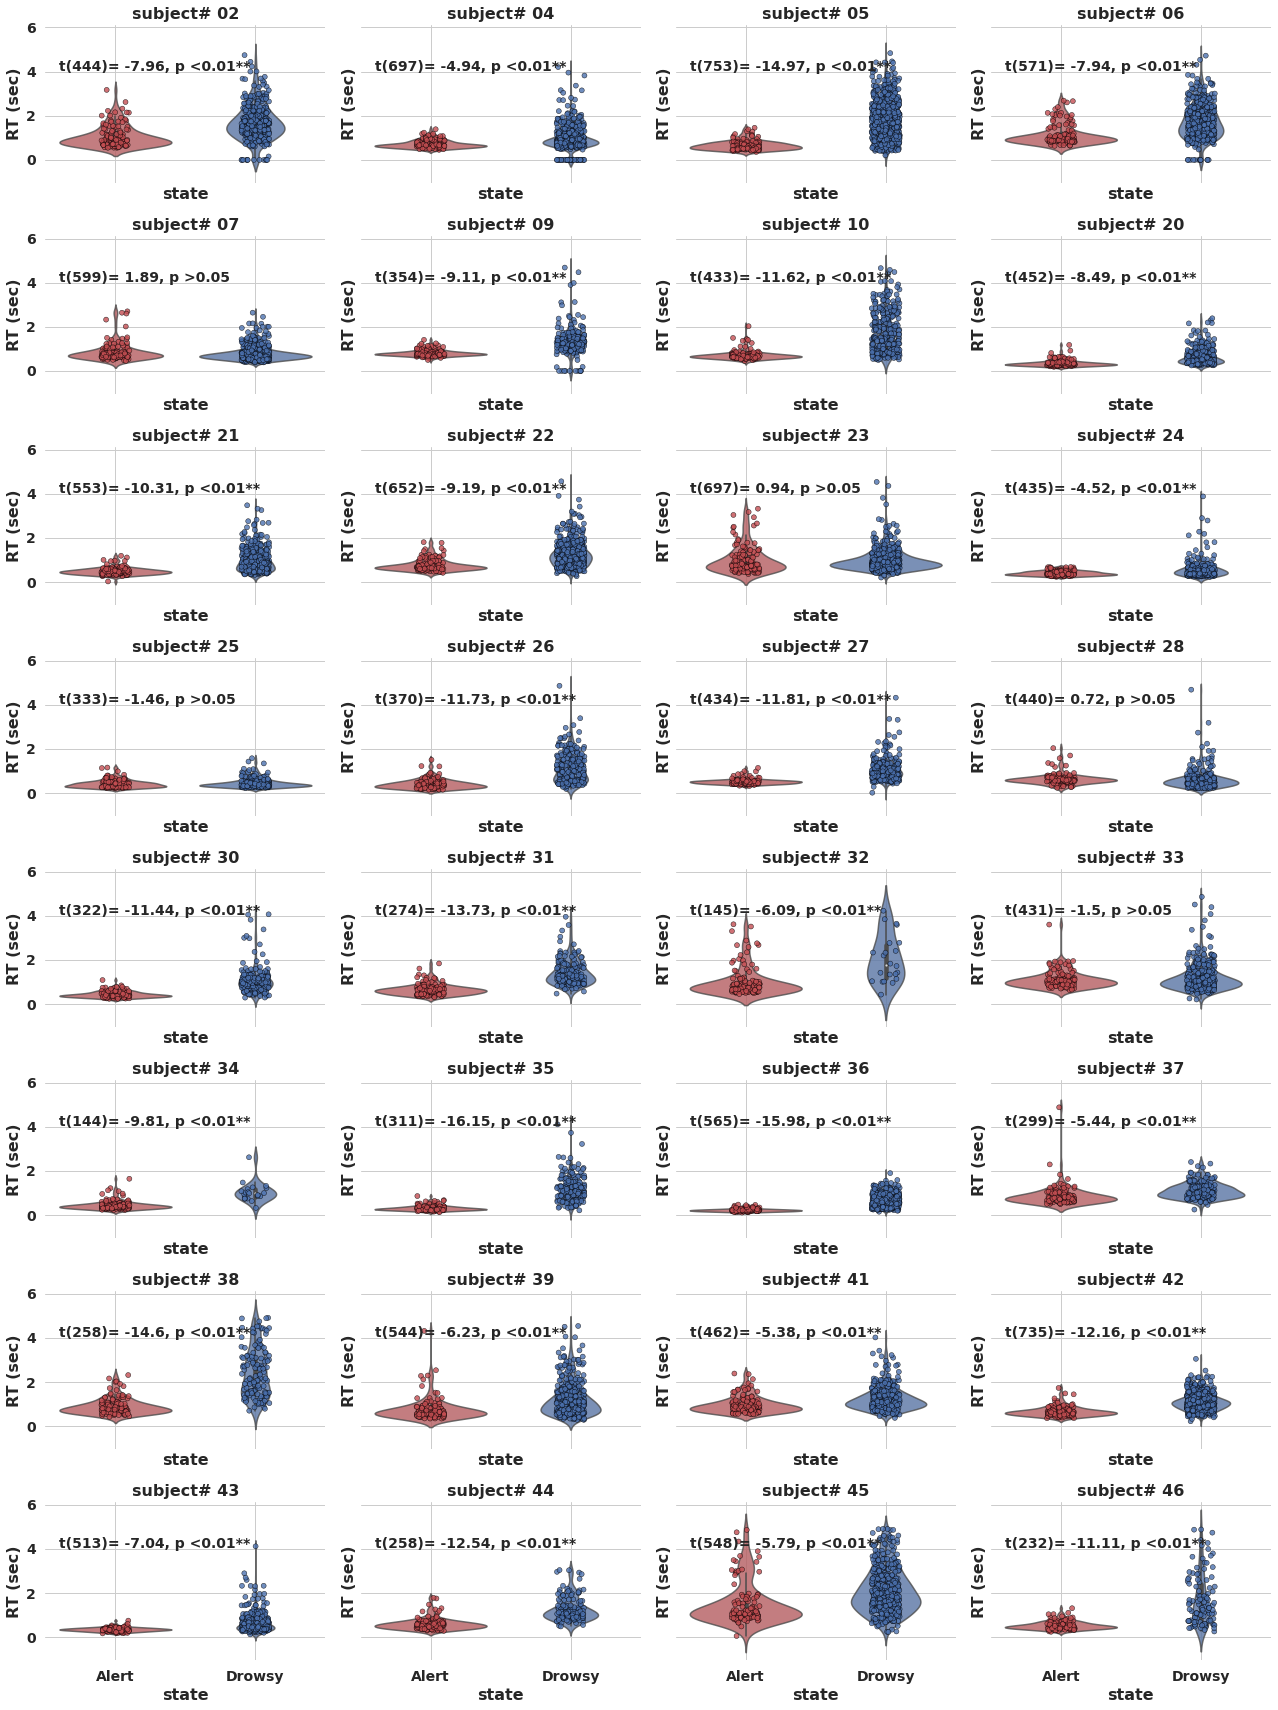

In [57]:
tPlot, axes = plt.subplots(figsize=(18, 24),
        nrows=8, ncols=4, sharex=True, sharey=True)

for s, subject in enumerate(subjects):  # Loop across each subject
        rowidx = s//4
        colidx = s%4
        titlestr = 'subject#' + ' ' + subject
        summarystat_df = pd.DataFrame()
        stat_data,summarystat_df = process_RTs(subject, summarystat_df)
        summarystat_df = summarystat_df[['subject', 't_stat', 'df', 'p_val']]
        plot_RTs(data = stat_data, summarystat = summarystat_df, pal = pal, ax = axes[rowidx,colidx], 
              x_label = 'state', y_label = 'RT (sec)',title = titlestr)
        
plt.tight_layout()
plt.box(False)
plt.grid(True)
plt.savefig(fig_dir + "suppl_RTvariation_allsubject" + ".png", format='png', dpi=240, transparent=False)        